# Process to identify high priority locations to develop

This notebook takes a cleaned up dataset of businesses from the Yelp database and generates all the output needed to identify high priority locations to develop, according to the process we have established.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import json
import numpy as np
import pandas as pd
from math import sin, cos, sqrt, atan2, radians
import mplleaflet
import itertools

First we'll read in our cleaned up file of all open and closed businesses and check the basic stats.

In [2]:
with open("bus_metro2.json", "rt") as infile:
    dfb = pd.read_json(infile)

In [3]:
dfb.describe()

,latitude,longitude,review_count,stars
count,85893.000000,85893.000000,85893.000000,85893.000000
mean,37.034622,-99.108007,34.342228,3.694859
std,5.389235,27.436247,108.631631,0.946031
min,32.865882,-115.386550,3.000000,1.000000
25%,33.506766,-115.062625,5.000000,3.000000
50%,35.314214,-111.943739,10.000000,4.000000
75%,36.203094,-80.951101,26.000000,4.500000
max,56.033777,8.549249,6200.000000,5.000000


Next we'll get a list of all the metro areas in the DataFrame.

In [4]:
metros = dfb.metro.unique()
metros

array(['Phoenix', 'Las Vegas', 'Pittsburgh', 'Montreal', 'Madison',
       'Edinburgh', 'Charlotte', 'Urb-Champ', 'Waterloo', 'Karlsruhe'], dtype=object)

### Putting each business into a latitude/longitude cell in the raster

We will assign all the businesses to a cell in an imaginary grid or 'raster' for a metro area, based on their latitude/longitude.

We use the term 'bin' for a group of latitudes or longitudes e.g. we put all latitudes from 49.100 to 49.199 into bin '2'.  Each cell in the raster for a metro can be referenced by the combination of its longitude bin number and its latitude bin number.

Now we specify the latitude and longitude groupings we are going to want.  This is done by creating a dictionary that allows us to specify the cell size in miles.  This can be different for each metro if we want.  Choice of an appropriate mesh size is arrived at by experimenting with different sizes.

In [5]:
cell_miles = {'Phoenix':0.5, 'Las Vegas':0.5, 'Pittsburgh':0.25, 'Montreal':0.25, 'Madison':0.25,
              'Edinburgh':0.25, 'Charlotte':0.5, 'Urb-Champ':0.25, 'Waterloo':0.25, 'Karlsruhe':0.25}

Locations of businesses are specified by degrees of latitude and longitude.  When converting these into cells based on miles we need to account for the fact that the degrees of longitude per mile varies with latitude.  Within a metro area that doesn't vary materially, so we can just base a conversion factor on the average latitude of each of the metros.

In [6]:
mean_lats = dfb.groupby("metro").latitude.mean()
print(mean_lats)

metro
Charlotte     35.185885
Edinburgh     55.949160
Karlsruhe     49.002978
Las Vegas     36.121854
Madison       43.079685
Montreal      45.510861
Phoenix       33.483838
Pittsburgh    40.436389
Urb-Champ     40.112776
Waterloo      43.460278
Name: latitude, dtype: float64


We are going to want to eventually have the ability to create complete rasters for the metros, including cells that don't have any businesses.  To make that work well we need to set steps for the cell bins that are exact integers rather than floats, otherwise we run into issues with float rounding.

We'll choose to use one millionth of a degree of lat or long as a basic unit.  (One millionth of a degree of lat or long is roughly 10cm at the equator, so accurate enough for any needs we have).

We create a dictionary to contain the steps (sized in millionths of a degree) for the latitude and longitude binning, and print out to check.

In [7]:
lat_steps = {metro: int((size / 69.172) * 1e6) for metro, size in cell_miles.items()}

long_steps = {metro: int((size / (69.172 * cos(radians(mean_lats[metro])))) * 1e6) for metro,size in cell_miles.items()}

In [8]:
print(lat_steps)
print(long_steps)

{'Karlsruhe': 3614, 'Charlotte': 7228, 'Phoenix': 7228, 'Waterloo': 3614, 'Pittsburgh': 3614, 'Edinburgh': 3614, 'Urb-Champ': 3614, 'Madison': 3614, 'Las Vegas': 7228, 'Montreal': 3614}
{'Karlsruhe': 5509, 'Charlotte': 8844, 'Phoenix': 8666, 'Waterloo': 4979, 'Pittsburgh': 4748, 'Edinburgh': 6454, 'Urb-Champ': 4725, 'Madison': 4948, 'Las Vegas': 8948, 'Montreal': 5157}


First we create new fields in the dataframe and fill them with the lat and long values to turn into bins

In [9]:
dfb["lat_bin"] = dfb.latitude
dfb["long_bin"] = dfb.longitude
dfb

,attributes,categories,city,full_address,hours,latitude,longitude,metro,name,neighborhoods,open,review_count,stars,state,type,lat_bin,long_bin
--0ZoBTQWQra1FxD4rBWmg,{'Accepts Credit Cards': False},"[Property Management, Home Services, Real Estate]",Phoenix,"2920 E Camelback Rd\nSte100\nPhoenix, AZ 85016","{'Thursday': {'open': '09:00', 'close': '17:00...",33.510773,-112.018737,Phoenix,Bourquin Residential Group,[],True,4,2.0,AZ,business,33.510773,-112.018737
--1emggGHgoG6ipd_RMb-g,"{'Accepts Credit Cards': True, 'Parking': {'st...","[Food, Convenience Stores]",Las Vegas,"3280 S Decatur Blvd\nWestside\nLas Vegas, NV 8...",{},36.130531,-115.207238,Las Vegas,Sinclair,[Westside],True,4,4.0,NV,business,36.130531,-115.207238
--4Pe8BZ6gj57VFL5mUE8g,"{'Accepts Credit Cards': True, 'Parking': {'st...","[Shopping, Office Equipment]",Phoenix,"21001 North Tatum Blvd. #24\nPhoenix, AZ 85050",{},33.676354,-111.973651,Phoenix,Office Max,[],True,9,3.0,AZ,business,33.676354,-111.973651
--5jkZ3-nUPZxUvtcbr8Uw,"{'Alcohol': 'none', 'Wheelchair Accessible': T...","[Greek, Vegetarian, Mediterranean, Restaurants]",Scottsdale,"1336 N Scottsdale Rd\nScottsdale, AZ 85257","{'Tuesday': {'open': '11:00', 'close': '21:00'...",33.463373,-111.926908,Phoenix,Mika's Greek,[],True,127,4.5,AZ,business,33.463373,-111.926908
--7PRjnsjMA6uhPK8mW13Q,{},"[Bars, Nightlife]",Pittsburgh,"3160 Library Rd\nPittsburgh, PA 15234",{},40.371878,-80.008930,Pittsburgh,Castle Tavern,[],True,3,2.5,PA,business,40.371878,-80.008930
--AKjxBmhm9DWrh-e0hTOw,"{'Delivery': False, 'Waiter Service': True, 'G...","[Restaurants, Italian]",Laval,"993 Boulevard Saint-Martin Ouest\nLaval, QC H7...","{'Tuesday': {'open': '11:00', 'close': '22:00'...",45.572509,-73.720293,Montreal,Grigio,[],True,6,4.5,QC,business,45.572509,-73.720293
--BlvDO_RG2yElKu9XA1_g,"{'Alcohol': 'none', 'Wheelchair Accessible': T...","[Sushi Bars, Hawaiian, Chinese, Restaurants]",Scottsdale,"14870 N Northsight Blvd\nSte 103\nScottsdale, ...","{'Tuesday': {'open': '10:30', 'close': '21:00'...",33.621605,-111.899066,Phoenix,Asian Island,[],True,122,4.0,AZ,business,33.621605,-111.899066
--Dl2rW_xO8GuYBomlg9zw,{'By Appointment Only': True},"[Medical Centers, Health & Medical]",Las Vegas,"4505 S Maryland Pkwy\nUniversity\nLas Vegas, N...",{},36.110940,-115.141514,Las Vegas,UNLV Student Health Center,[University],True,7,4.5,NV,business,36.110940,-115.141514
--LzU4UT9rysIDXbhoWHiQ,"{'Accepts Credit Cards': True, 'Parking': {'st...","[Hair Salons, Day Spas, Nail Salons, Beauty & ...",Pittsburgh,"99 S 10th St\nSouth Side\nPittsburgh, PA 15203","{'Thursday': {'open': '11:00', 'close': '20:00...",40.427499,-79.988313,Pittsburgh,Lunasea Salon+Day Spa,[South Side],True,10,4.5,PA,business,40.427499,-79.988313
--NCcmQqh_NZbjW1S5XsGQ,"{'Price Range': 2, 'Parking': {'street': True,...","[Bakeries, Food, Desserts]",Montréal,"291 Beaudoin Street\nSud-Ouest\nMontréal, QC H...","{'Thursday': {'open': '08:00', 'close': '18:00...",45.474274,-73.585614,Montreal,Sweet Lee's Rustic Bakery,[Sud-Ouest],False,5,4.5,QC,business,45.474274,-73.585614


Now we want to transform each of the actual latitudes and longitudes for a business into a bin for that metro area's raster of cells.

The raster for each metro needs to be set with a specific reference point.  It's convenient to define that to just be the minimum lat and long for any business in each of the metros.

We are going to want to join on these columns later, so floats could be problematic as they are not exact whereas ints will be predictable.

In [10]:
for metro in metros:
    # get specific reference points for the grid in a metro area from the minimums
    first_lat = int(dfb[(dfb.metro == metro)].latitude.min() * 1e6)
    first_long = int(dfb[(dfb.metro == metro)].longitude.min() * 1e6)
    
    # define the functions to transform each of the lats and longs to bins
    to_lat_bin = lambda x: (int(x*1e6) - first_lat) // lat_steps[metro]
    to_long_bin = lambda x: (int(x*1e6) - first_long) // long_steps[metro]
    
    # Apply the functions only to this particular metro
    dfb.ix[dfb.metro == metro, "lat_bin"] = dfb.ix[dfb.metro == metro, "lat_bin"].map(to_lat_bin)
    dfb.ix[dfb.metro == metro, "long_bin"] = dfb.ix[dfb.metro == metro, "long_bin"].map(to_long_bin)

dfb[["lat_bin","long_bin"]] = dfb[["lat_bin","long_bin"]].astype(int)
dfb

,attributes,categories,city,full_address,hours,latitude,longitude,metro,name,neighborhoods,open,review_count,stars,state,type,lat_bin,long_bin
--0ZoBTQWQra1FxD4rBWmg,{'Accepts Credit Cards': False},"[Property Management, Home Services, Real Estate]",Phoenix,"2920 E Camelback Rd\nSte100\nPhoenix, AZ 85016","{'Thursday': {'open': '09:00', 'close': '17:00...",33.510773,-112.018737,Phoenix,Bourquin Residential Group,[],True,4,2.0,AZ,business,89,106
--1emggGHgoG6ipd_RMb-g,"{'Accepts Credit Cards': True, 'Parking': {'st...","[Food, Convenience Stores]",Las Vegas,"3280 S Decatur Blvd\nWestside\nLas Vegas, NV 8...",{},36.130531,-115.207238,Las Vegas,Sinclair,[Westside],True,4,4.0,NV,business,24,20
--4Pe8BZ6gj57VFL5mUE8g,"{'Accepts Credit Cards': True, 'Parking': {'st...","[Shopping, Office Equipment]",Phoenix,"21001 North Tatum Blvd. #24\nPhoenix, AZ 85050",{},33.676354,-111.973651,Phoenix,Office Max,[],True,9,3.0,AZ,business,112,111
--5jkZ3-nUPZxUvtcbr8Uw,"{'Alcohol': 'none', 'Wheelchair Accessible': T...","[Greek, Vegetarian, Mediterranean, Restaurants]",Scottsdale,"1336 N Scottsdale Rd\nScottsdale, AZ 85257","{'Tuesday': {'open': '11:00', 'close': '21:00'...",33.463373,-111.926908,Phoenix,Mika's Greek,[],True,127,4.5,AZ,business,82,117
--7PRjnsjMA6uhPK8mW13Q,{},"[Bars, Nightlife]",Pittsburgh,"3160 Library Rd\nPittsburgh, PA 15234",{},40.371878,-80.008930,Pittsburgh,Castle Tavern,[],True,3,2.5,PA,business,6,19
--AKjxBmhm9DWrh-e0hTOw,"{'Delivery': False, 'Waiter Service': True, 'G...","[Restaurants, Italian]",Laval,"993 Boulevard Saint-Martin Ouest\nLaval, QC H7...","{'Tuesday': {'open': '11:00', 'close': '22:00'...",45.572509,-73.720293,Montreal,Grigio,[],True,6,4.5,QC,business,47,53
--BlvDO_RG2yElKu9XA1_g,"{'Alcohol': 'none', 'Wheelchair Accessible': T...","[Sushi Bars, Hawaiian, Chinese, Restaurants]",Scottsdale,"14870 N Northsight Blvd\nSte 103\nScottsdale, ...","{'Tuesday': {'open': '10:30', 'close': '21:00'...",33.621605,-111.899066,Phoenix,Asian Island,[],True,122,4.0,AZ,business,104,120
--Dl2rW_xO8GuYBomlg9zw,{'By Appointment Only': True},"[Medical Centers, Health & Medical]",Las Vegas,"4505 S Maryland Pkwy\nUniversity\nLas Vegas, N...",{},36.110940,-115.141514,Las Vegas,UNLV Student Health Center,[University],True,7,4.5,NV,business,22,27
--LzU4UT9rysIDXbhoWHiQ,"{'Accepts Credit Cards': True, 'Parking': {'st...","[Hair Salons, Day Spas, Nail Salons, Beauty & ...",Pittsburgh,"99 S 10th St\nSouth Side\nPittsburgh, PA 15203","{'Thursday': {'open': '11:00', 'close': '20:00...",40.427499,-79.988313,Pittsburgh,Lunasea Salon+Day Spa,[South Side],True,10,4.5,PA,business,21,23
--NCcmQqh_NZbjW1S5XsGQ,"{'Price Range': 2, 'Parking': {'street': True,...","[Bakeries, Food, Desserts]",Montréal,"291 Beaudoin Street\nSud-Ouest\nMontréal, QC H...","{'Thursday': {'open': '08:00', 'close': '18:00...",45.474274,-73.585614,Montreal,Sweet Lee's Rustic Bakery,[Sud-Ouest],False,5,4.5,QC,business,20,79


Now let's take a look at Phoenix as an example, grouping on the lat_bin and long_bin values.

In [11]:
dfb[dfb.metro == "Phoenix"].groupby(("lat_bin","long_bin")).count()

attributes  categories  city  full_address  hours  latitude  \
lat_bin long_bin                                                                
0       93                 1           1     1             1      1         1   
        136                1           1     1             1      1         1   
        138                1           1     1             1      1         1   
        145                1           1     1             1      1         1   
1       94                 1           1     1             1      1         1   
        135                2           2     2             2      2         2   
        136                5           5     5             5      5         5   
        137               25          25    25            25     25        25   
        138               13          13    13            13     13        13   
        139               13          13    13            13     13        13   
        140               12          12    12            12     12        12   
        141               24          24    24            24     24        24   
        142                3           3     3             3      3         3   
        143                5           5     5             5      5         5   
        144                5           5     5             5      5         5   
        145                5           5     5             5      5         5   
2       126                1           1     1             1      1         1   
        136                7           7     7             7      7         7   
        137                1           1     1             1      1         1   
        138                2           2     2             2      2         2   
        139                3           3     3             3      3         3   
        140                3           3     3             3      3         3   
        141                2           2     2             2      2         2   
        142                1           1     1             1      1         1   
        143                4           4     4             4      4         4   
        145               18          18    18            18     18        18   
        146                1           1     1             1      1         1   
3       108                1           1     1             1      1         1   
        133                1           1     1             1      1         1   
        135                2           2     2             2      2         2   
...                      ...         ...   ...           ...    ...       ...   
145     92                 2           2     2             2      2         2   
        93                 1           1     1             1      1         1   
146     29                 1           1     1             1      1         1   
        77                 1           1     1             1      1         1   
        92                 2           2     2             2      2         2   
        94                 2           2     2             2      2         2   
147     28                 1           1     1             1      1         1   
148     18                 1           1     1             1      1         1   
149     27                 1           1     1             1      1         1   
150     18                 1           1     1             1      1         1   
151     18                 1           1     1             1      1         1   
        19                 2           2     2             2      2         2   
        20                 2           2     2             2      2         2   
        21                 5           5     5             5      5         5   
        26                 1           1     1             1      1         1   
        186                1           1     1             1      1         1   
152     19                 1           1     1   

And we can try plotting all the combinations of bins in Phoenix as a scatter to check it looks like our Phoenix map.  Yes it does!

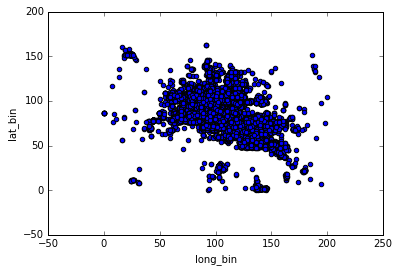

In [12]:
dfb[dfb.metro == "Phoenix"].plot(y = "lat_bin", x = "long_bin", kind = "scatter")

### Creating a full raster of the metro area for all cells, including empty ones

We want to be able to visualize a metro area using a pcolormesh type chart which will include empty cells too.   In order to do that we will use a raster of all the possible combinations of lat/long bin in a metro area.  We can then use that as a base to merge with the information on actual outlets and then plot pcolormesh type charts.

This is pretty straightforward.

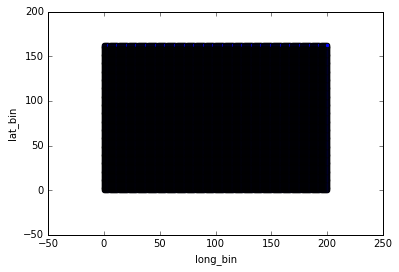

In [13]:
metro = "Phoenix"
lat_points  = range(dfb[(dfb.metro == metro)].lat_bin.min(),dfb[(dfb.metro == metro)].lat_bin.max() + 1)
long_points  = range(dfb[(dfb.metro == metro)].long_bin.min(),dfb[(dfb.metro == metro)].long_bin.max() + 1)
full_raster = np.array(list(itertools.product(long_points, lat_points)))
mesh = pd.DataFrame(full_raster, columns = ["long_bin", "lat_bin"])
mesh.plot(x = "long_bin", y = "lat_bin", kind = "scatter")

### Identifying premises that are potential targets for conversion

In addition to identifying the general areas of opportunity, we want to be able to get even more specific and help our customers by identifying potential locations for our new business that might be able to be easily converted from their current use.

For some categories lke restaurants it is much easier to put a new restaurant into a location that already has all the kitchen plumbing/electrical fixtures etc that a restaurant needs, rather than just having to start from a blank space.

The two filters we are interested in for our current purposes are businesses that are either:
 - currently a restaurant, but with very bad reviews (2.5 or less) so possibly not doing well
 - was previously a restaurant but no business is shown open at that address right now

First we create a 'bad_open' column and set it to 1 if it's a restaurant that is open now and has 2.5 stars or less as its rating.

In [14]:
dfb["bad_open"] = 0
dfb.ix[(dfb.categories.map(lambda x: "Restaurants" in x)) &
       (dfb.open == True) &
       (dfb.stars <= 2.5),
        "bad_open"] = 1
dfb

,attributes,categories,city,full_address,hours,latitude,longitude,metro,name,neighborhoods,open,review_count,stars,state,type,lat_bin,long_bin,bad_open
--0ZoBTQWQra1FxD4rBWmg,{'Accepts Credit Cards': False},"[Property Management, Home Services, Real Estate]",Phoenix,"2920 E Camelback Rd\nSte100\nPhoenix, AZ 85016","{'Thursday': {'open': '09:00', 'close': '17:00...",33.510773,-112.018737,Phoenix,Bourquin Residential Group,[],True,4,2.0,AZ,business,89,106,0
--1emggGHgoG6ipd_RMb-g,"{'Accepts Credit Cards': True, 'Parking': {'st...","[Food, Convenience Stores]",Las Vegas,"3280 S Decatur Blvd\nWestside\nLas Vegas, NV 8...",{},36.130531,-115.207238,Las Vegas,Sinclair,[Westside],True,4,4.0,NV,business,24,20,0
--4Pe8BZ6gj57VFL5mUE8g,"{'Accepts Credit Cards': True, 'Parking': {'st...","[Shopping, Office Equipment]",Phoenix,"21001 North Tatum Blvd. #24\nPhoenix, AZ 85050",{},33.676354,-111.973651,Phoenix,Office Max,[],True,9,3.0,AZ,business,112,111,0
--5jkZ3-nUPZxUvtcbr8Uw,"{'Alcohol': 'none', 'Wheelchair Accessible': T...","[Greek, Vegetarian, Mediterranean, Restaurants]",Scottsdale,"1336 N Scottsdale Rd\nScottsdale, AZ 85257","{'Tuesday': {'open': '11:00', 'close': '21:00'...",33.463373,-111.926908,Phoenix,Mika's Greek,[],True,127,4.5,AZ,business,82,117,0
--7PRjnsjMA6uhPK8mW13Q,{},"[Bars, Nightlife]",Pittsburgh,"3160 Library Rd\nPittsburgh, PA 15234",{},40.371878,-80.008930,Pittsburgh,Castle Tavern,[],True,3,2.5,PA,business,6,19,0
--AKjxBmhm9DWrh-e0hTOw,"{'Delivery': False, 'Waiter Service': True, 'G...","[Restaurants, Italian]",Laval,"993 Boulevard Saint-Martin Ouest\nLaval, QC H7...","{'Tuesday': {'open': '11:00', 'close': '22:00'...",45.572509,-73.720293,Montreal,Grigio,[],True,6,4.5,QC,business,47,53,0
--BlvDO_RG2yElKu9XA1_g,"{'Alcohol': 'none', 'Wheelchair Accessible': T...","[Sushi Bars, Hawaiian, Chinese, Restaurants]",Scottsdale,"14870 N Northsight Blvd\nSte 103\nScottsdale, ...","{'Tuesday': {'open': '10:30', 'close': '21:00'...",33.621605,-111.899066,Phoenix,Asian Island,[],True,122,4.0,AZ,business,104,120,0
--Dl2rW_xO8GuYBomlg9zw,{'By Appointment Only': True},"[Medical Centers, Health & Medical]",Las Vegas,"4505 S Maryland Pkwy\nUniversity\nLas Vegas, N...",{},36.110940,-115.141514,Las Vegas,UNLV Student Health Center,[University],True,7,4.5,NV,business,22,27,0
--LzU4UT9rysIDXbhoWHiQ,"{'Accepts Credit Cards': True, 'Parking': {'st...","[Hair Salons, Day Spas, Nail Salons, Beauty & ...",Pittsburgh,"99 S 10th St\nSouth Side\nPittsburgh, PA 15203","{'Thursday': {'open': '11:00', 'close': '20:00...",40.427499,-79.988313,Pittsburgh,Lunasea Salon+Day Spa,[South Side],True,10,4.5,PA,business,21,23,0
--NCcmQqh_NZbjW1S5XsGQ,"{'Price Range': 2, 'Parking': {'street': True,...","[Bakeries, Food, Desserts]",Montréal,"291 Beaudoin Street\nSud-Ouest\nMontréal, QC H...","{'Thursday': {'open': '08:00', 'close': '18:00...",45.474274,-73.585614,Montreal,Sweet Lee's Rustic Bakery,[Sud-Ouest],False,5,4.5,QC,business,20,79,0


Identify restaurants that are now closed and no restaurant is shown open at that address

**TOM** - I edited this box to use all open businesses as the cross check for addresses. While doing some checking in the Scottsdale area, I noticed the address 4321 N Scottsdale Rd\nScottsdale, AZ 85251, which showed up a closed restaurant (Saddle Ranch Chop House) and an open food/brewery but not tagged as a restaurant (Two Brothers Tap House and Brewery). 

By making this adjustment, it removed approximately 500 closed businesses (from 4724 down to 4232), roughly 9%. I still think there are too many closed restaurants showing up. There was another I looked at that seems open but the new address has a suite number the old one did not have. So I think we don't stress this layer, but show how it could work if tied to a better real estate database.

In [15]:
open_rests = dfb[(dfb.categories.map(lambda x: "Restaurants" in x)) &
                 (dfb.open == True)]
open_all = dfb[dfb.open == True]  # Added to catch instances where new business is not restaurant
closed_rests = dfb[(dfb.categories.map(lambda x: "Restaurants" in x)) &
                 (dfb.open == False)]
reopened = closed_rests.merge(open_all, on = "full_address", how = "inner")
unopened = closed_rests[(~closed_rests.full_address.isin(reopened.full_address))]
unopened
dfb["unopened"] = 0
dfb.ix[(dfb.full_address.isin(unopened.full_address)), "unopened"] = 1

Calculate a few totals to show how this is working

In [16]:
print("restaurants that are open now: ", open_rests.name.count())
print("restaurants that were open but are now closed:", closed_rests.name.count())
print("restaurants that are closed but now a new one is reopened at that address:", reopened.name_x.count())
print("Unique combinations of address and name at closed restaurants", len(reopened.groupby(['full_address','name_x'])))
print("restaurants that are closed and no new one at that address:", unopened.name.count())

restaurants that are open now:  20124
restaurants that were open but are now closed: 6603
restaurants that are closed but now a new one is reopened at that address: 5349
Unique combinations of address and name at closed restaurants 2369
restaurants that are closed and no new one at that address: 4232


In [17]:
dfb[dfb.unopened == 1]

,attributes,categories,city,full_address,hours,latitude,longitude,metro,name,neighborhoods,open,review_count,stars,state,type,lat_bin,long_bin,bad_open,unopened
--zgHBiQpr8H2ZqSdGmguQ,"{'Alcohol': 'beer_and_wine', 'Wheelchair Acces...","[Buffets, Chinese, Restaurants]",Las Vegas,"3743 South Las Vegas Bl\nThe Strip\nLas Vegas,...",{},36.106542,-115.172040,Las Vegas,China Star Buffet,[The Strip],False,6,3.0,NV,business,21,23,0,1
-024YEtnIsPQCrMSHCKLQw,{},"[Cafes, Restaurants]",Montréal,"1750 Saint-Denis Rue\nVille-Marie\nMontréal, Q...",{},45.515736,-73.565138,Montreal,Presse Cafe,[Ville-Marie],False,4,3.5,QC,business,31,83,0,1
-0tJ4FwcNtJjil-ZUTy30Q,"{'Alcohol': 'none', 'Good For Groups': True, '...","[Food, Coffee & Tea, Internet Cafes, Breakfast...",Edinburgh,9 Croall Place\nLeith Walk\nLeith\nEdinburgh E...,"{'Tuesday': {'open': '08:30', 'close': '16:00'...",55.961614,-3.180362,Edinburgh,Cafe No 9,[Leith],False,6,4.5,EDH,business,29,34,0,1
-1JzlIdItrARuq2JW63rKA,"{'Alcohol': 'beer_and_wine', 'Wheelchair Acces...","[Food, Specialty Food, Barbeque, Restaurants]",Charlotte,"6538 N Tryon St\nCharlotte, NC 28213","{'Tuesday': {'open': '11:00', 'close': '21:00'...",35.277916,-80.765813,Charlotte,Old Hickory House Restaurant,[],False,63,3.5,NC,business,38,32,0,1
-2gyHPSL8pJjkSe5Ozzw6Q,"{'Alcohol': 'full_bar', 'Good For Groups': Tru...","[Mexican, Restaurants]",Scottsdale,"7111 E Thomas Rd\nScottsdale, AZ 85257","{'Tuesday': {'open': '11:00', 'close': '22:00'...",33.479935,-111.927770,Phoenix,Caldero,[],False,37,4.0,AZ,business,84,117,0,1
-3yID57d0cMpYZZr13CTHw,"{'Parking': {'street': False, 'valet': False, ...","[Breakfast & Brunch, Mediterranean, Restaurants]",Edinburgh,138 Bruntsfield Pl\nBruntsfield\nEdinburgh EH1...,"{'Tuesday': {'open': '09:00', 'close': '19:00'...",55.936569,-3.208410,Edinburgh,Ooud Kitchen,[Bruntsfield],False,7,3.0,EDH,business,22,29,0,1
-4THvPKs5M3P2036bJ50GA,"{'Alcohol': 'none', 'Good For Groups': False, ...","[Mexican, Restaurants]",Henderson,"10110 S Eastern Ave\nAnthem\nHenderson, NV 89052",{},36.005633,-115.112289,Las Vegas,Super Burrito,[Anthem],False,12,3.0,NV,business,7,30,0,1
-587aHcWTqF_OgPxEqHl5A,"{'Good For Groups': True, 'Waiter Service': Tr...","[Barbeque, Restaurants]",Montréal,1029 Rue du Marché-Central\nAhunstic-Cartiervi...,"{'Tuesday': {'open': '11:00', 'close': '23:00'...",45.534702,-73.659275,Montreal,Dunn'ss Famous,[Ahunstic-Cartierville],False,6,2.0,QC,business,36,65,0,1
-5biAn5qQYk3X5NYlA98pw,"{'Alcohol': 'beer_and_wine', 'Wheelchair Acces...","[Mexican, Restaurants]",Las Vegas,"953 E Sahara Ave\nSte E8\nEastside\nLas Vegas,...",{},36.143672,-115.140960,Las Vegas,Birrieria Jalisco,"[Eastside, Downtown]",False,6,3.0,NV,business,26,27,0,1
-7XuLxfYwZ9x72mEKXdv0A,"{'Alcohol': 'none', 'Good For Groups': True, '...","[Chinese, Restaurants]",Phoenix,"5037 W Thomas Rd\nPhoenix, AZ 85035","{'Tuesday': {'open': '11:00', 'close': '08:30'...",33.480010,-112.167718,Phoenix,Lin's Golden Chinese Restaurant,[],False,10,4.5,AZ,business,84,89,0,1


Note:  This approach will code a 1 for any business operating at a location where a closed restaurant once was.  This is what we want as we are looking for locations which might be easy to turn back into a restaurant. 

In [18]:
pd.crosstab(dfb.bad_open, dfb.unopened, margins = True)

unopened,0,1,All
bad_open,,,
0,78147,4336,82483
1,3410,0,3410
All,81557,4336,85893


In [19]:
dfb["convertable"] = dfb.bad_open + dfb.unopened
dfb

,attributes,categories,city,full_address,hours,latitude,longitude,metro,name,neighborhoods,open,review_count,stars,state,type,lat_bin,long_bin,bad_open,unopened,convertable
--0ZoBTQWQra1FxD4rBWmg,{'Accepts Credit Cards': False},"[Property Management, Home Services, Real Estate]",Phoenix,"2920 E Camelback Rd\nSte100\nPhoenix, AZ 85016","{'Thursday': {'open': '09:00', 'close': '17:00...",33.510773,-112.018737,Phoenix,Bourquin Residential Group,[],True,4,2.0,AZ,business,89,106,0,0,0
--1emggGHgoG6ipd_RMb-g,"{'Accepts Credit Cards': True, 'Parking': {'st...","[Food, Convenience Stores]",Las Vegas,"3280 S Decatur Blvd\nWestside\nLas Vegas, NV 8...",{},36.130531,-115.207238,Las Vegas,Sinclair,[Westside],True,4,4.0,NV,business,24,20,0,0,0
--4Pe8BZ6gj57VFL5mUE8g,"{'Accepts Credit Cards': True, 'Parking': {'st...","[Shopping, Office Equipment]",Phoenix,"21001 North Tatum Blvd. #24\nPhoenix, AZ 85050",{},33.676354,-111.973651,Phoenix,Office Max,[],True,9,3.0,AZ,business,112,111,0,0,0
--5jkZ3-nUPZxUvtcbr8Uw,"{'Alcohol': 'none', 'Wheelchair Accessible': T...","[Greek, Vegetarian, Mediterranean, Restaurants]",Scottsdale,"1336 N Scottsdale Rd\nScottsdale, AZ 85257","{'Tuesday': {'open': '11:00', 'close': '21:00'...",33.463373,-111.926908,Phoenix,Mika's Greek,[],True,127,4.5,AZ,business,82,117,0,0,0
--7PRjnsjMA6uhPK8mW13Q,{},"[Bars, Nightlife]",Pittsburgh,"3160 Library Rd\nPittsburgh, PA 15234",{},40.371878,-80.008930,Pittsburgh,Castle Tavern,[],True,3,2.5,PA,business,6,19,0,0,0
--AKjxBmhm9DWrh-e0hTOw,"{'Delivery': False, 'Waiter Service': True, 'G...","[Restaurants, Italian]",Laval,"993 Boulevard Saint-Martin Ouest\nLaval, QC H7...","{'Tuesday': {'open': '11:00', 'close': '22:00'...",45.572509,-73.720293,Montreal,Grigio,[],True,6,4.5,QC,business,47,53,0,0,0
--BlvDO_RG2yElKu9XA1_g,"{'Alcohol': 'none', 'Wheelchair Accessible': T...","[Sushi Bars, Hawaiian, Chinese, Restaurants]",Scottsdale,"14870 N Northsight Blvd\nSte 103\nScottsdale, ...","{'Tuesday': {'open': '10:30', 'close': '21:00'...",33.621605,-111.899066,Phoenix,Asian Island,[],True,122,4.0,AZ,business,104,120,0,0,0
--Dl2rW_xO8GuYBomlg9zw,{'By Appointment Only': True},"[Medical Centers, Health & Medical]",Las Vegas,"4505 S Maryland Pkwy\nUniversity\nLas Vegas, N...",{},36.110940,-115.141514,Las Vegas,UNLV Student Health Center,[University],True,7,4.5,NV,business,22,27,0,0,0
--LzU4UT9rysIDXbhoWHiQ,"{'Accepts Credit Cards': True, 'Parking': {'st...","[Hair Salons, Day Spas, Nail Salons, Beauty & ...",Pittsburgh,"99 S 10th St\nSouth Side\nPittsburgh, PA 15203","{'Thursday': {'open': '11:00', 'close': '20:00...",40.427499,-79.988313,Pittsburgh,Lunasea Salon+Day Spa,[South Side],True,10,4.5,PA,business,21,23,0,0,0
--NCcmQqh_NZbjW1S5XsGQ,"{'Price Range': 2, 'Parking': {'street': True,...","[Bakeries, Food, Desserts]",Montréal,"291 Beaudoin Street\nSud-Ouest\nMontréal, QC H...","{'Thursday': {'open': '08:00', 'close': '18:00...",45.474274,-73.585614,Montreal,Sweet Lee's Rustic Bakery,[Sud-Ouest],False,5,4.5,QC,business,20,79,0,0,0


### Identifying how  outlet density and average review score vary by cell

First we build a groupby object to create a count of outlets per raster point, and the average review score, only for open stores.

In [20]:
grouped = dfb[(dfb.metro == "Phoenix") &
              (dfb.categories.map(lambda x: "Pizza" in x)) &
              (dfb.open == True)].groupby(("lat_bin","long_bin"))

Then create a base DataFrame for doing the binning by aggregating the average star rating value and counting the number of outlets, then resetting the index to create lat_bin and long bin reference columns.

In [21]:
base = grouped.agg({"stars": "mean", "name": "count"})
base.reset_index(inplace = True)
base = base.rename(columns = {"name":"cell_count", "stars":"cell_stars"})
base.head()

,lat_bin,long_bin,cell_count,cell_stars
0,1,137,1,3.00
1,1,138,1,1.00
2,1,139,1,4.00
3,1,141,2,3.25
4,2,143,1,3.50


Now we add categorical columns to put counts and average stars into a number of specified bins. 

In [22]:
base["count_bin"] = pd.cut(base.cell_count,[0,1,2,3,4,16])
base["rating_bin"] = pd.cut(base.cell_stars,[0,2.5,3,3.5,4,4.5,5])

In [23]:
pd.crosstab(base.count_bin, base.rating_bin, margins = True)

rating_bin,"(0, 2.5]","(2.5, 3]","(3, 3.5]","(3.5, 4]","(4, 4.5]","(4.5, 5]",All
count_bin,,,,,,,
"(0, 1]",115,92,113,136,44,5,505
"(1, 2]",11,25,32,36,8,1,113
"(2, 3]",1,8,11,9,1,0,30
"(3, 4]",0,0,5,3,1,0,9
"(4, 16]",0,2,1,2,1,0,6
All,127,127,162,186,55,6,663


### Coding the points in the raster based on the density/review of the outlets in that cell

We need to code each cell with its rating_bin and count_bin, including empty cells.

We do this by joining the DataFrame 'mesh' which we created above to have all the lat_bins and long_bins for the metro area, to the 'base' Dataframe we just created, using the mesh table as the master.  This will put in a NaN for all the lat/long bins where we don't have restaurants, which we'll turn to zero for convenience when plotting later.

In [24]:
coded = mesh.merge(base, on = ["long_bin","lat_bin"], how = "left")
coded.fillna(0, inplace = True)

In [25]:
coded

,long_bin,lat_bin,cell_count,cell_stars,count_bin,rating_bin
0,0,0,0.0,0.0,0,0
1,0,1,0.0,0.0,0,0
2,0,2,0.0,0.0,0,0
3,0,3,0.0,0.0,0,0
4,0,4,0.0,0.0,0,0
5,0,5,0.0,0.0,0,0
6,0,6,0.0,0.0,0,0
7,0,7,0.0,0.0,0,0
8,0,8,0.0,0.0,0,0
9,0,9,0.0,0.0,0,0


Let's rerun the crosstab to demonstrate that it looks right.

In [26]:
pd.crosstab(coded.count_bin, coded.rating_bin, margins = True)

rating_bin,0,"(0, 2.5]","(2.5, 3]","(3, 3.5]","(3.5, 4]","(4, 4.5]","(4.5, 5]",All
count_bin,,,,,,,,
0,32301,0,0,0,0,0,0,32301
"(0, 1]",0,115,92,113,136,44,5,505
"(1, 2]",0,11,25,32,36,8,1,113
"(2, 3]",0,1,8,11,9,1,0,30
"(3, 4]",0,0,0,5,3,1,0,9
"(4, 16]",0,0,2,1,2,1,0,6
All,32301,127,127,162,186,55,6,32964


### Prioritizing the cells based on review and outlet count

Next we need to prioritize the cells.  Now add the rules to set the priority.  We are going to set it so a lower score is a lower priority.  We will set all empty cells to priority zero.

Rather than applying a broad rule, we are doing this in a very cell-by-cell way so we can fine-tune it exactly the way we think makes sense. This is an ugly way to do it, but works for now.

In [27]:
priorities = pd.DataFrame(list(itertools.product(coded.rating_bin.unique(), coded.count_bin.unique())))
priorities.columns = ["rating_bin","count_bin"]
priorities.sort_values(["rating_bin","count_bin"], inplace = True)

priorities["priority"] = 0

# all the places where count is only one, or ratings are the highest are 1
priorities.loc[((priorities.count_bin == "(0, 1]") &
                (priorities.rating_bin != 0)), "priority"] = 1
priorities.loc[((priorities.count_bin != 0) &
                (priorities.rating_bin == "(4.5, 5]")), "priority"] = 1

priorities.loc[((priorities.count_bin == "(1, 2]") &
                (priorities.rating_bin == "(4, 4.5]")), "priority"] = 2

priorities.loc[((priorities.count_bin == "(1, 2]") &
                (priorities.rating_bin == "(3.5, 4]")), "priority"] = 3
priorities.loc[((priorities.count_bin == "(2, 3]") &
                (priorities.rating_bin == "(4, 4.5]")), "priority"] = 3

priorities.loc[((priorities.count_bin == "(1, 2]") &
                (priorities.rating_bin == "(3.5, 4]")), "priority"] = 3
priorities.loc[((priorities.count_bin == "(1, 2]") &
                (priorities.rating_bin == "(3, 3.5]")), "priority"] = 3
priorities.loc[((priorities.count_bin == "(2, 3]") &
                (priorities.rating_bin == "(4, 4.5]")), "priority"] = 3
priorities.loc[((priorities.count_bin == "(3, 4]") &
                (priorities.rating_bin == "(4, 4.5]")), "priority"] = 3
priorities.loc[((priorities.count_bin == "(4, 16]") &
                (priorities.rating_bin == "(4, 4.5]")), "priority"] = 3

priorities.loc[((priorities.count_bin == "(1, 2]") &
                (priorities.rating_bin == "(0, 2.5]")), "priority"] = 4
priorities.loc[((priorities.count_bin == "(1, 2]") &
                (priorities.rating_bin == "(2.5, 3]")), "priority"] = 4
priorities.loc[((priorities.count_bin == "(2, 3]") &
                (priorities.rating_bin == "(3.5, 4]")), "priority"] = 4
priorities.loc[((priorities.count_bin == "(3, 4]") &
                (priorities.rating_bin == "(3.5, 4]")), "priority"] = 4

priorities.loc[((priorities.count_bin == "(2, 3]") &
                (priorities.rating_bin == "(3, 3.5]")), "priority"] = 5
priorities.loc[((priorities.count_bin == "(4, 16]") &
                (priorities.rating_bin == "(3.5, 4]")), "priority"] = 5

priorities.loc[((priorities.count_bin == "(2, 3]") &
                (priorities.rating_bin == "(2.5, 3]")), "priority"] = 6
priorities.loc[((priorities.count_bin == "(3, 4]") &
                (priorities.rating_bin == "(3, 3.5]")), "priority"] = 6

priorities.loc[((priorities.count_bin == "(2, 3]") &
                (priorities.rating_bin == "(0, 2.5]")), "priority"] = 7
priorities.loc[((priorities.count_bin == "(3, 4]") &
                (priorities.rating_bin == "(2.5, 3]")), "priority"] = 7
priorities.loc[((priorities.count_bin == "(4, 16]") &
                (priorities.rating_bin == "(3, 3.5]")), "priority"] = 7


priorities.loc[((priorities.count_bin == "(3, 4]") &
                (priorities.rating_bin == "(0, 2.5]")), "priority"] = 8
priorities.loc[((priorities.count_bin == "(4, 16]") &
                (priorities.rating_bin == "(2.5, 3]")), "priority"] = 8

priorities.loc[((priorities.count_bin == "(4, 16]") &
                (priorities.rating_bin == "(0, 2.5]")), "priority"] = 9

Now run a pivot to check that all the priorities are set the way we want them.

In [28]:
priorities.pivot(index='count_bin', columns='rating_bin', values='priority')

rating_bin,0,"(0, 2.5]","(2.5, 3]","(3, 3.5]","(3.5, 4]","(4, 4.5]","(4.5, 5]"
count_bin,,,,,,,
0,0,0,0,0,0,0,0
"(0, 1]",0,1,1,1,1,1,1
"(1, 2]",0,4,4,3,3,2,1
"(2, 3]",0,7,6,5,4,3,1
"(3, 4]",0,8,7,6,4,3,1
"(4, 16]",0,9,8,7,5,3,1


Yes they are.  And we can reconfirm how the datatframe looks below

In [29]:
priorities.head()

,rating_bin,count_bin,priority
0,0,0,0
1,0,"(0, 1]",0
2,0,"(1, 2]",0
3,0,"(2, 3]",0
5,0,"(3, 4]",0


### Applying the priority rating to businesses and cells

Now we can use this to add a prioritization field to the dataframe representing a raster of all cells in Phoenix

In [30]:
coded = coded.merge(priorities, on = ["count_bin", "rating_bin"], how = "left")

Now we'll pull a dataframe that is all open or closed pizza restaurants in the metro area.

Then we add all the relevant data from the master raster to each outlet, open or closed, which gives us coding for characteristics (average rating, count, priority) of the lat/long bin that the pizza place is in.

In [31]:
outlets = dfb[(dfb.metro == "Phoenix") & (dfb.open == True) &
                 (dfb.categories.map(lambda x: "Pizza" in x))]
outlets = outlets.merge(coded, on = ["long_bin", "lat_bin"], how = "left")
outlets.head()

,attributes,categories,city,full_address,hours,latitude,longitude,metro,name,neighborhoods,...,lat_bin,long_bin,bad_open,unopened,convertable,cell_count,cell_stars,count_bin,rating_bin,priority
0,"{'Alcohol': 'beer_and_wine', 'Wheelchair Acces...","[Pizza, Italian, Sandwiches, Restaurants]",Phoenix,"4404 N Central Ave\nPhoenix, AZ 85012","{'Tuesday': {'open': '16:00', 'close': '20:00'...",33.500621,-112.074311,Phoenix,Pane Bianco,[],...,87,100,0,0,0,1.0,4.000,"(0, 1]","(3.5, 4]",1
1,"{'Alcohol': 'full_bar', 'Wheelchair Accessible...","[Restaurants, Pizza, Italian]",Maricopa,"20800 N John Wayne Pkwy\nSte 118\nMaricopa, AZ...",{},33.068257,-112.047297,Phoenix,Brooklyn Boys Italian Restaurant,[],...,27,103,0,0,0,4.0,3.375,"(3, 4]","(3, 3.5]",6
2,"{'Alcohol': 'none', 'Wheelchair Accessible': T...","[Kosher, Pizza, Restaurants]",Phoenix,"5224 N 7th St\nPhoenix, AZ 85014","{'Tuesday': {'open': '10:00', 'close': '21:00'...",33.513936,-112.065219,Phoenix,Manhattan Pizzeria and Subshop,[],...,89,101,0,0,0,4.0,3.500,"(3, 4]","(3, 3.5]",6
3,"{'Alcohol': 'full_bar', 'Good For Groups': Tru...","[Bars, Pubs, Nightlife, Restaurants, Karaoke, ...",Tempe,"414 S Mill Ave\nSte 118\nTempe, AZ 85281","{'Tuesday': {'open': '10:30', 'close': '04:00'...",33.425965,-111.940251,Phoenix,4one4 Pizza,[],...,77,115,0,0,0,6.0,3.750,"(4, 16]","(3.5, 4]",5
4,"{'Delivery': True, 'Waiter Service': False, 'G...","[Pizza, Restaurants]",Scottsdale,"2009 N Scottsdale Rd\nScottsdale, AZ 85257",{},33.470445,-111.925769,Phoenix,Papa John's Pizza,[],...,83,117,1,0,1,1.0,2.500,"(0, 1]","(0, 2.5]",1


### Generating the plots

Now we have two master dataframes with all the information we need for plots

coded -- contains every raster point in the metro area

outlets -- contains every open or closed pizza place in the metro area

Start with reproducing the color mesh of counts. Got to pull the values out of the DataFrame and shape them correctly based on the long/lat counts, and transpose them so the lat/long will display on the correct axes. Apply color bars, limit the axes, etc.

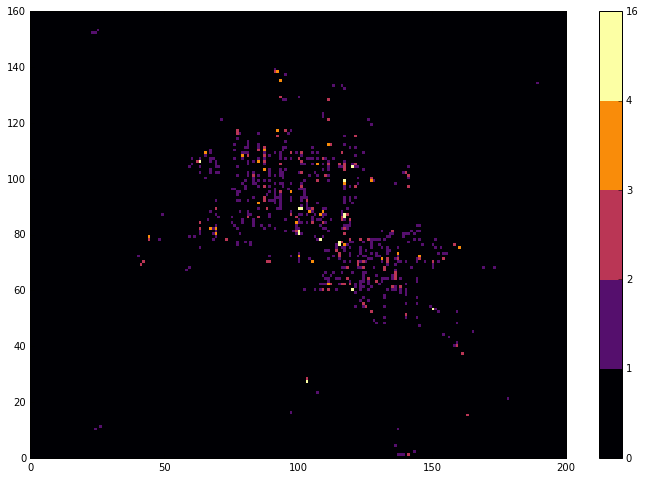

In [32]:
vals = np.array(coded.cell_count)
vals = vals.reshape(coded.long_bin.max() + 1,coded.lat_bin.max() + 1)
vals = vals.transpose()
bounds = np.array([0,1,2,3,4,16])
normer = colors.BoundaryNorm(boundaries = bounds, ncolors = 256)
fig = plt.figure()
fig.set_size_inches(12,8)
ax1 = fig.add_subplot(1,1,1)
ax1.pcolormesh(vals)
ax1.set_xlim([0,200])
ax1.set_ylim([0,160])
im1 = ax1.pcolormesh(vals, cmap = "inferno", norm = normer)
cbar = plt.colorbar(im1)
plt.show()

Try plotting with the background set to white. Included a few color ramps I like.

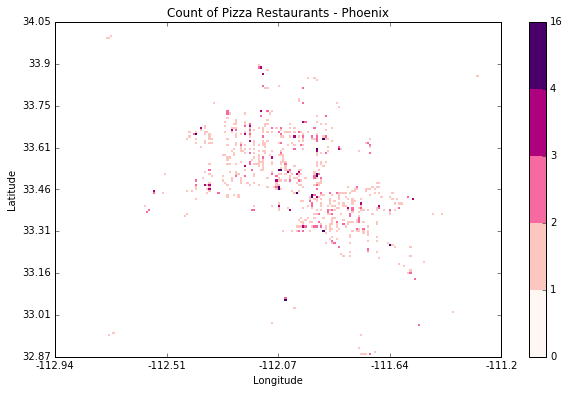

In [33]:
vals = np.array(coded.cell_count)
vals = vals.reshape(coded.long_bin.max() + 1,coded.lat_bin.max() + 1)
vals = vals.transpose()
bounds = np.array([0,1,2,3,4,16]) # to use viridis_r, delete the 0 here.
normer = colors.BoundaryNorm(boundaries = bounds, ncolors = 256)
fig = plt.figure()
fig.set_size_inches(10,6)
ax1 = fig.add_subplot(1,1,1)
ax1.pcolormesh(vals)
ax1.set_xlim([0,200])
ax1.set_ylim([0,160])
ax1.set_xticklabels(['{:0.5}'.format(x) for x in np.linspace(dfb[dfb.metro == 'Phoenix'].longitude.min(),
                                                             dfb[dfb.metro == 'Phoenix'].longitude.max(),5)])
ax1.set_yticklabels(['{:0.4}'.format(x) for x in np.linspace(dfb[dfb.metro == 'Phoenix'].latitude.min(),
                                                             dfb[dfb.metro == 'Phoenix'].latitude.max(), 9)])
ax1.set_ylabel('Latitude')
ax1.set_xlabel('Longitude')
vals = np.ma.masked_where(vals == 0, vals)
#cmap = plt.get_cmap('autumn_r')
#cmap = plt.get_cmap('viridis_r') 
cmap = plt.get_cmap('RdPu') 
cmap.set_bad(color = 'white')
im1 = ax1.pcolormesh(vals, cmap = cmap, norm = normer)
cbar = plt.colorbar(im1)
plt.title('Count of Pizza Restaurants - Phoenix')
plt.savefig('pizza_counts.png')

Now reproducing the same thing for the mesh of star ratings

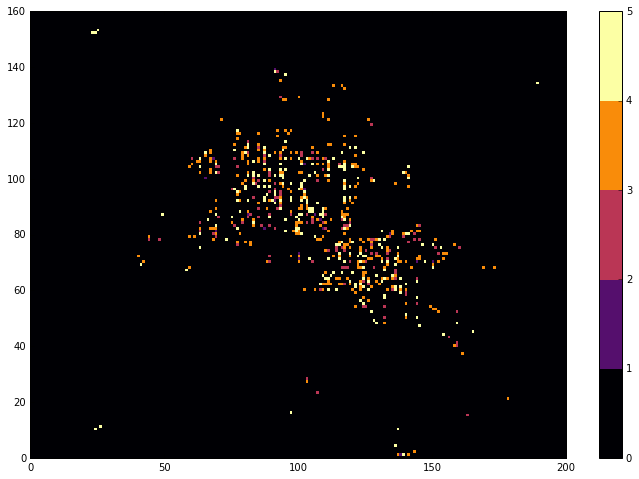

In [34]:
vals = np.array(coded.cell_stars)
vals = vals.reshape(coded.long_bin.max() + 1,coded.lat_bin.max() + 1)
vals = vals.transpose()
bounds = np.array([0,1,2,3,4,5])
normer = colors.BoundaryNorm(boundaries = bounds, ncolors = 256)
fig = plt.figure()
fig.set_size_inches(12,8)
ax1 = fig.add_subplot(1,1,1)
ax1.pcolormesh(vals)
ax1.set_xlim([0,200])
ax1.set_ylim([0,160])
im1 = ax1.pcolormesh(vals, cmap = "inferno", norm = normer)
cbar = plt.colorbar(im1)
plt.show()

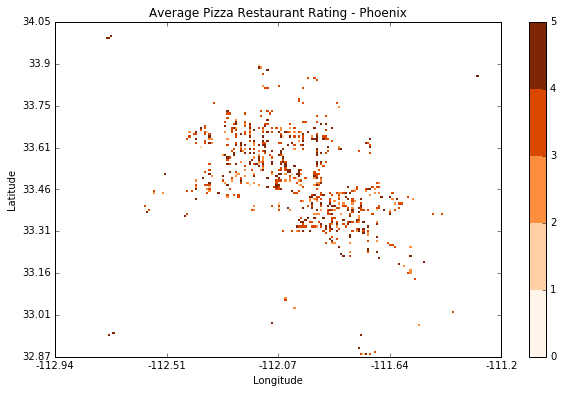

In [35]:
vals = np.array(coded.cell_stars)
vals = vals.reshape(coded.long_bin.max() + 1,coded.lat_bin.max() + 1)
vals = vals.transpose()
bounds = np.array([0,1,2,3,4,5])
normer = colors.BoundaryNorm(boundaries = bounds, ncolors = 256)
fig = plt.figure()
fig.set_size_inches(10,6)
ax1 = fig.add_subplot(1,1,1)
ax1.pcolormesh(vals)
ax1.set_xlim([0,200])
ax1.set_ylim([0,160])
vals = np.ma.masked_where(vals == 0, vals)
#cmap = plt.get_cmap('autumn_r')
#cmap = plt.get_cmap('viridis_r') 
cmap = plt.get_cmap('Oranges') 
cmap.set_bad(color = 'white')
ax1.set_xticklabels(['{:0.5}'.format(x) for x in np.linspace(dfb[dfb.metro == 'Phoenix'].longitude.min(),
                                                             dfb[dfb.metro == 'Phoenix'].longitude.max(),5)])
ax1.set_yticklabels(['{:0.4}'.format(x) for x in np.linspace(dfb[dfb.metro == 'Phoenix'].latitude.min(),
                                                             dfb[dfb.metro == 'Phoenix'].latitude.max(), 9)])
ax1.set_ylabel('Latitude')
ax1.set_xlabel('Longitude')
im1 = ax1.pcolormesh(vals, cmap = cmap, norm = normer)
cbar = plt.colorbar(im1)
plt.title('Average Pizza Restaurant Rating - Phoenix')
plt.savefig('avg_pizza_rating.png')

And now do it for the priority coding (playing around with different colormaps

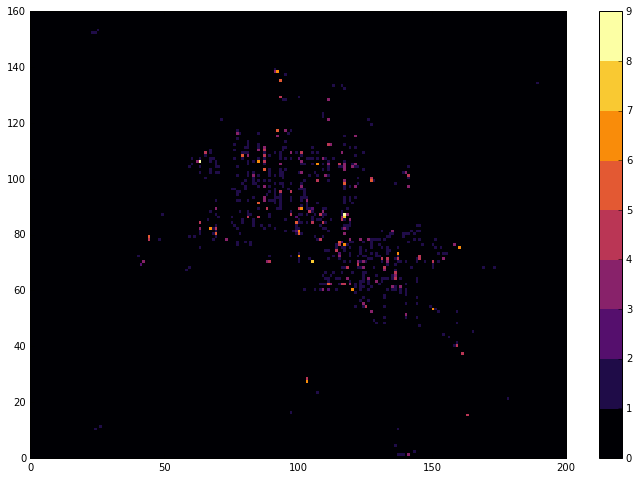

In [36]:
vals = np.array(coded.priority)
vals = vals.reshape(coded.long_bin.max() + 1,coded.lat_bin.max() + 1)
vals = vals.transpose()
bounds = np.array([0,1,2,3,4,5,6,7,8,9])
normer = colors.BoundaryNorm(boundaries = bounds, ncolors = 256)
fig = plt.figure()
fig.set_size_inches(12,8)
ax1 = fig.add_subplot(1,1,1)
ax1.pcolormesh(vals)
ax1.set_xlim([0,200])
ax1.set_ylim([0,160])
im1 = ax1.pcolormesh(vals, cmap = "inferno", norm = normer)
cbar = plt.colorbar(im1)
plt.show()

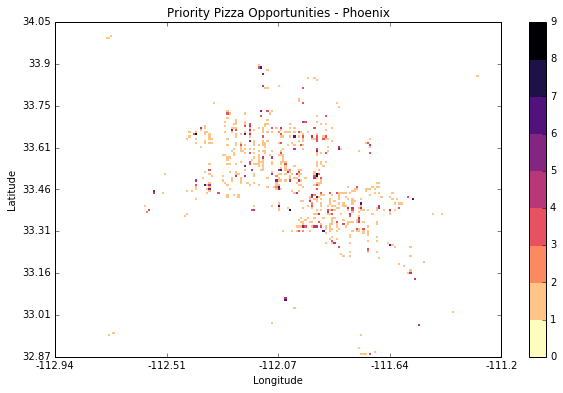

In [37]:
vals = np.array(coded.priority)
vals = vals.reshape(coded.long_bin.max() + 1,coded.lat_bin.max() + 1)
vals = vals.transpose()
bounds = np.array([0,1,2,3,4,5,6,7,8,9])
normer = colors.BoundaryNorm(boundaries = bounds, ncolors = 256)
fig = plt.figure()
fig.set_size_inches(10,6)
ax1 = fig.add_subplot(1,1,1)
ax1.pcolormesh(vals)
ax1.set_xlim([0,200])
ax1.set_ylim([0,160])
ax1.set_xticklabels(['{:0.5}'.format(x) for x in np.linspace(dfb[dfb.metro == 'Phoenix'].longitude.min(),
                                                             dfb[dfb.metro == 'Phoenix'].longitude.max(),5)])
ax1.set_yticklabels(['{:0.4}'.format(x) for x in np.linspace(dfb[dfb.metro == 'Phoenix'].latitude.min(),
                                                             dfb[dfb.metro == 'Phoenix'].latitude.max(), 9)])
ax1.set_ylabel('Latitude')
ax1.set_xlabel('Longitude')
vals = np.ma.masked_where(vals == 0, vals)
#cmap = plt.get_cmap('autumn_r')
cmap = plt.get_cmap('magma_r') 
#cmap = plt.get_cmap('summer_r') 
cmap.set_bad(color = 'white')
im1 = ax1.pcolormesh(vals, cmap = cmap, norm = normer)
cbar = plt.colorbar(im1)
plt.title('Priority Pizza Opportunities - Phoenix')
plt.savefig('priority_opportunities.png')

Now we can pull lists of pizza places based on their priority coding and plot them on a map by doing a scatter then mplleaflet.

Start simply by just pulling the highest priority bins and plotting them

In [38]:
best = outlets[outlets.priority == outlets.priority.max()]
best

,attributes,categories,city,full_address,hours,latitude,longitude,metro,name,neighborhoods,...,lat_bin,long_bin,bad_open,unopened,convertable,cell_count,cell_stars,count_bin,rating_bin,priority
62,"{'Alcohol': 'beer_and_wine', 'Wheelchair Acces...","[Pizza, Restaurants]",Scottsdale,"7321 E Shoeman Ln\nScottsdale, AZ 85251","{'Tuesday': {'open': '09:00', 'close': '04:00'...",33.500516,-111.923299,Phoenix,Joe's New York Pizza,[],...,87,117,0,0,0,5.0,3.0,"(4, 16]","(2.5, 3]",8
71,"{'Alcohol': 'full_bar', 'Good For Groups': Tru...","[Beer Gardens, Breakfast & Brunch, Pizza, Nigh...",Scottsdale,"7340 E. Indian Plaza\nScottsdale, AZ 85251","{'Tuesday': {'open': '15:00', 'close': '02:00'...",33.501689,-111.922772,Phoenix,Bottled Blonde,[],...,87,117,0,0,0,5.0,3.0,"(4, 16]","(2.5, 3]",8
101,"{'Alcohol': 'full_bar', 'Good For Groups': Tru...","[Pizza, Bars, American (Traditional), Nightlif...",Surprise,"16640 N Reems Rd\nSurprise, AZ 85374",{},33.636909,-112.394663,Phoenix,Tailgaters,[],...,106,63,0,0,0,5.0,3.0,"(4, 16]","(2.5, 3]",8
203,"{'Alcohol': 'none', 'Wheelchair Accessible': T...","[Italian, Pizza, Restaurants]",Scottsdale,"7111 E 5th Ave\nScottsdale, AZ 85251","{'Tuesday': {'open': '10:00', 'close': '20:00'...",33.498041,-111.928044,Phoenix,Best of Italy - Pizza & Subs,[],...,87,117,1,0,1,5.0,3.0,"(4, 16]","(2.5, 3]",8
294,"{'Alcohol': 'none', 'Wheelchair Accessible': T...","[Pizza, Restaurants]",Surprise,"15557 W Bell Rd\nSurprise, AZ 85374","{'Tuesday': {'open': '11:00', 'close': '21:00'...",33.636983,-112.395991,Phoenix,Papa Murphy's,[],...,106,63,0,0,0,5.0,3.0,"(4, 16]","(2.5, 3]",8
300,"{'By Appointment Only': False, 'Alcohol': 'ful...","[Food, Gelato, Pizza, Sandwiches, Restaurants]",Scottsdale,"4166 N Scottsdale Rd\nScottsdale, AZ 85251","{'Tuesday': {'open': '11:00', 'close': '23:00'...",33.496659,-111.926430,Phoenix,The Gelato Spot,[],...,87,117,0,0,0,5.0,3.0,"(4, 16]","(2.5, 3]",8
472,"{'Alcohol': 'beer_and_wine', 'Good For Groups'...","[Pizza, Restaurants]",Surprise,"15459 W Bell Rd\nSurprise, AZ 85374",{},33.637331,-112.392837,Phoenix,US Pizza,[],...,106,63,0,0,0,5.0,3.0,"(4, 16]","(2.5, 3]",8
719,"{'Alcohol': 'none', 'Good For Groups': False, ...","[Pizza, Restaurants]",Surprise,"15170 W Bell Rd\nSurprise, AZ 85374",{},33.638756,-112.389149,Phoenix,Papa John's Pizza,[],...,106,63,1,0,1,5.0,3.0,"(4, 16]","(2.5, 3]",8
801,"{'Alcohol': 'full_bar', 'Good For Groups': Tru...","[Sandwiches, Pizza, Chicken Wings, Restaurants]",Surprise,"15332 W Bell Rd\nSte 129\nSurprise, AZ 85374","{'Tuesday': {'open': '10:00', 'close': '00:00'...",33.639255,-112.390452,Phoenix,Domino's Pizza,[],...,106,63,0,0,0,5.0,3.0,"(4, 16]","(2.5, 3]",8
827,"{'Alcohol': 'beer_and_wine', 'Wheelchair Acces...","[Pizza, Restaurants]",Scottsdale,"7333 E Shoeman Ln\nScottsdale, AZ 85251",{},33.500525,-111.922690,Phoenix,Gus's NY Pizza Lounge,[],...,87,117,1,0,1,5.0,3.0,"(4, 16]","(2.5, 3]",8


Now we just plot them and display on a map.

In [39]:
# Plot the existing pizza locations in the highest priority zones

#best.plot(y = "latitude", x = "longitude", kind = "scatter")
#mplleaflet.show()

Next we'll just plot all pizza places and color their markers based on the priority of that bin.

Choosing to set a very large marker size so it's easy to see the points on the map when zoomed in close.  For a zoomed out map it's better to have a smaller marker size (control with the s=parameter).

In [40]:
# Commenting out because this is not in the report

#outlets.plot(y = "latitude", x = "longitude",
#               kind = "scatter", c = "priority", cmap = "viridis",
#               s = 200)
#mplleaflet.show(path = "map2.html")

Now we can plot all the potential locations we've identified in the priority areas that are either open restuarants with bad scores or closed restaurants that haven't reopened.

In [41]:
conversions = dfb[(dfb.metro == "Phoenix") &
                  (dfb.categories.map(lambda x: "Restaurants" in x)) &
                  (dfb.convertable == 1)]
conversions = conversions.merge(coded, on = ["long_bin", "lat_bin"], how = "left")
conversions.head()

,attributes,categories,city,full_address,hours,latitude,longitude,metro,name,neighborhoods,...,lat_bin,long_bin,bad_open,unopened,convertable,cell_count,cell_stars,count_bin,rating_bin,priority
0,"{'Alcohol': 'none', 'Has TV': True, 'Good For ...","[Burgers, Fast Food, Restaurants]",Phoenix,"4750 E Warner Rd\nPhoenix, AZ 85044",{},33.331156,-111.981475,Phoenix,McDonald's,[],...,64,110,1,0,1,1.0,4.00,"(0, 1]","(3.5, 4]",1
1,"{'Alcohol': 'none', 'Has TV': False, 'Good For...","[Fast Food, Restaurants]",Tempe,"525 W Broadway Rd\nTempe, AZ 85282",{},33.406914,-111.947277,Phoenix,Arby's,[],...,74,114,1,0,1,2.0,2.25,"(1, 2]","(0, 2.5]",4
2,"{'Alcohol': 'full_bar', 'Good For Groups': Tru...","[Mexican, Restaurants]",Scottsdale,"7111 E Thomas Rd\nScottsdale, AZ 85257","{'Tuesday': {'open': '11:00', 'close': '22:00'...",33.479935,-111.927770,Phoenix,Caldero,[],...,84,117,0,1,1,0.0,0.00,0,0,0
3,"{'Alcohol': 'none', 'Good For Groups': True, '...","[Mexican, Restaurants]",Chandler,"6185 W Chandler Blvd\nChandler, AZ 85226",{},33.304775,-111.947948,Phoenix,Filiberto's,[],...,60,114,1,0,1,1.0,4.00,"(0, 1]","(3.5, 4]",1
4,"{'Alcohol': 'none', 'Good For Groups': True, '...","[Chinese, Restaurants]",Phoenix,"5037 W Thomas Rd\nPhoenix, AZ 85035","{'Tuesday': {'open': '11:00', 'close': '08:30'...",33.480010,-112.167718,Phoenix,Lin's Golden Chinese Restaurant,[],...,84,89,0,1,1,0.0,0.00,0,0,0


In [42]:
best_cv = conversions[conversions.priority == conversions.priority.max()]
best_cv

,attributes,categories,city,full_address,hours,latitude,longitude,metro,name,neighborhoods,...,lat_bin,long_bin,bad_open,unopened,convertable,cell_count,cell_stars,count_bin,rating_bin,priority
8,"{'Alcohol': 'full_bar', 'Good For Groups': Tru...","[Bars, American (Traditional), Cocktail Bars, ...",Scottsdale,"4363 N 75th St\nScottsdale, AZ 85251","{'Thursday': {'open': '16:00', 'close': '02:00...",33.500169,-111.919817,Phoenix,American Junkie,[],...,87,117,0,1,1,5.0,3.0,"(4, 16]","(2.5, 3]",8
41,"{'Alcohol': 'none', 'Good For Groups': True, '...","[American (Traditional), Restaurants]",Scottsdale,"7272 E Indian School Rd\nScottsdale, AZ 85251","{'Thursday': {'open': '07:00', 'close': '14:30...",33.495696,-111.924473,Phoenix,Pacific's Cafe,[],...,87,117,0,1,1,5.0,3.0,"(4, 16]","(2.5, 3]",8
83,"{'Alcohol': 'full_bar', 'Wheelchair Accessible...","[Bars, American (New), Nightlife, Lounges, Res...",Scottsdale,"7144 E Stetson Drive\nSte 250\nScottsdale, AZ ...","{'Tuesday': {'open': '11:00', 'close': '23:00'...",33.499705,-111.927222,Phoenix,Canal Restaurant,[],...,87,117,0,1,1,5.0,3.0,"(4, 16]","(2.5, 3]",8
108,"{'Alcohol': 'full_bar', 'Wheelchair Accessible...","[Japanese, Restaurants]",Scottsdale,"7133 E Stetson Dr\nScottsdale, AZ 85251",{},33.499193,-111.927532,Phoenix,Sea Saw,[],...,87,117,0,1,1,5.0,3.0,"(4, 16]","(2.5, 3]",8
159,"{'Alcohol': 'full_bar', 'Good For Groups': Tru...","[Bars, Latin American, Mexican, Nightlife, Res...",Scottsdale,"7323 E Shoeman Ln\nScottsdale, AZ 85251","{'Tuesday': {'open': '11:00', 'close': '22:00'...",33.500515,-111.923177,Phoenix,Ricky's Tacos & Beer,[],...,87,117,0,1,1,5.0,3.0,"(4, 16]","(2.5, 3]",8
211,"{'Alcohol': 'full_bar', 'Wheelchair Accessible...","[Bars, Restaurants, Nightlife, Lounges, Italian]",Scottsdale,"4425 N Buckboard Trl.\nScottsdale, AZ 85251",{},33.501260,-111.923363,Phoenix,Cin-Cin Restaurant,[],...,87,117,0,1,1,5.0,3.0,"(4, 16]","(2.5, 3]",8
224,"{'Alcohol': 'full_bar', 'Wheelchair Accessible...","[Bars, Restaurants, Nightlife, Lounges, Italian]",Scottsdale,"7133 E Stetson Dr\nScottsdale, AZ 85250","{'Thursday': {'open': '17:00', 'close': '22:00...",33.499499,-111.927402,Phoenix,Digestif,[],...,87,117,0,1,1,5.0,3.0,"(4, 16]","(2.5, 3]",8
422,"{'Alcohol': 'full_bar', 'Wheelchair Accessible...",[Restaurants],Scottsdale,"7217 E 4th Ave\nScottsdale, AZ 85251",{},33.497794,-111.925401,Phoenix,Medizona,[],...,87,117,0,1,1,5.0,3.0,"(4, 16]","(2.5, 3]",8
482,"{'Alcohol': 'full_bar', 'Wheelchair Accessible...","[Sushi Bars, Restaurants]",Scottsdale,"4302 N Scottsdale Rd\nScottsdale, AZ 85251","{'Tuesday': {'open': '11:00', 'close': '23:00'...",33.498661,-111.926367,Phoenix,Stingray Sushi,[],...,87,117,0,1,1,5.0,3.0,"(4, 16]","(2.5, 3]",8
674,"{'Alcohol': 'none', 'Wheelchair Accessible': T...","[Italian, Pizza, Restaurants]",Scottsdale,"7111 E 5th Ave\nScottsdale, AZ 85251","{'Tuesday': {'open': '10:00', 'close': '20:00'...",33.498041,-111.928044,Phoenix,Best of Italy - Pizza & Subs,[],...,87,117,1,0,1,5.0,3.0,"(4, 16]","(2.5, 3]",8


In [43]:
best_cv.plot(y = "latitude", x = "longitude", kind = "scatter", c= 'r', s = 150)
mplleaflet.show(path = "best_conversions.html")

Plot a map of all conversion opportunities with a priority above 5, displayed by priority

In [44]:
conversions[conversions.priority >= 5].plot(y = "latitude", x = "longitude",
               kind = "scatter", s = 150, c = 'priority', cmap = 'autumn_r')
mplleaflet.show(path = 'all_conversions.html')

Generate legend

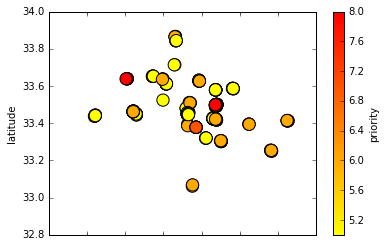

In [45]:
conversions[conversions.priority >= 5].plot(y = "latitude", x = "longitude",
               kind = "scatter", s = 150, c = 'priority', cmap = 'autumn_r', legend = True)
plt.savefig('all_conversions_legend.png')

Create a figure that has the conversion opportunities separated by closed vs poorly rated, and includes pizza restaurants

In [46]:
fig, axes = plt.subplots(nrows=3, ncols=3)
# Closed Restaurants - not reopened
conversions[(conversions.open == False)&(conversions.priority >=5)].plot(ax = axes[0,0], y = "latitude",
                                                                         x = "longitude", kind = "scatter",
                                                                         s = 70, c = 'gray', marker = 's')     
# Existing Pizza
outlets.plot(ax = axes[0,1], y = "latitude", x = "longitude", kind = "scatter", c = "stars", cmap = "jet_r",
             s = 200, legend = True)
# Conversion Opportunities - Poorly Rated Restaurants
conversions[(conversions.open == True)&(conversions.priority >=5)].plot(ax = axes[0,2], y = "latitude", 
                                                                        x = "longitude", kind = "scatter",
                                                                        s = 300, c = 'orange', marker = '*')
mplleaflet.show(path = 'combo_map.html')

Generate legend

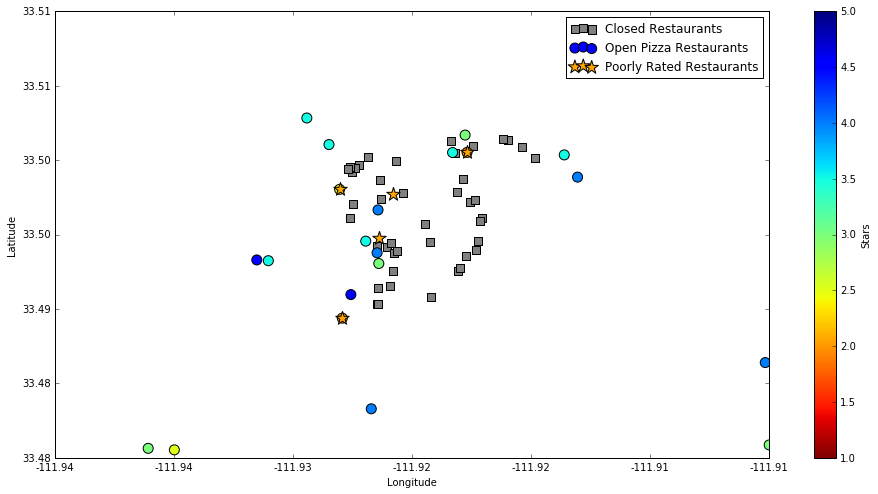

In [47]:
import matplotlib.cm as cm


#fig, ax = plt.subplots()
ax = conversions[(conversions.open == False)&(conversions.priority >=5)].plot(y = "latitude",
                                                                         x = "longitude", kind = "scatter",
                                                                         s = 70, c = 'gray', marker = 's',
                                                                         legend = True, figsize = (16,8),
                                                                         label = 'Closed Restaurants', xlim = [-111.94, -111.91], ylim = [33.48, 33.51])     


m = cm.ScalarMappable(cmap = cm.jet_r)
m.set_array(outlets.stars)
plt.colorbar(m, label = 'Stars')
outlets.plot(ax = ax, y = "latitude", x = "longitude", kind = "scatter", c = "stars", cmap = "jet_r",
             s = 100, legend = True, figsize = (16,8), colorbar = False, label = 'Open Pizza Restaurants')

conversions[(conversions.open == True)&(conversions.priority >=5)].plot(ax = ax, y = "latitude", 
                                                                        x = "longitude", kind = "scatter",
                                                                        s = 200, c = 'orange', marker = '*',
                                                                        legend = True, figsize = (16,8),
                                                                        label = 'Poorly Rated Restaurants')
ax.set_xticklabels(['{:3.2f}'.format(x) for x in ax.get_xticks()])
ax.set_yticklabels(['{:3.2f}'.format(x) for x in ax.get_yticks()])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('combo_map_legends')

Possible combo plot with all restaurants. Not used.

In [48]:
#fig, axes = plt.subplots(nrows=3, ncols=3)
#conversions[conversions.open == False].plot(ax = axes[0,0], y = "latitude", x = "longitude", kind = "scatter", s = 70, c = 'white', marker = 's')     
#dfb[(dfb.metro == 'Phoenix') & (dfb.categories.map(lambda x: "Restaurants" in x)) & (dfb.open == True)].plot(
#    ax = axes[0,1], y = "latitude", x = "longitude", kind = "scatter", s = 100, c = "stars", cmap = "YlGn")  
#conversions[conversions.open == True].plot(ax = axes[0,2], y = "latitude", x = "longitude", kind = "scatter", s = 200, c = 'orange', marker = '*')

#mplleaflet.show()

In [49]:
#dfb[(dfb.metro == 'Phoenix') & (dfb.categories.map(lambda x: "Restaurants" in x)) & (dfb.open == True)].plot(
#    y = "latitude", x = "longitude", kind = "scatter", s = 100) #c = "stars", cmap = "YlGn", 
#mplleaflet.show()

In [50]:
conversions.columns

Index(['attributes', 'categories', 'city', 'full_address', 'hours', 'latitude',
       'longitude', 'metro', 'name', 'neighborhoods', 'open', 'review_count',
       'stars', 'state', 'type', 'lat_bin', 'long_bin', 'bad_open', 'unopened',
       'convertable', 'cell_count', 'cell_stars', 'count_bin', 'rating_bin',
       'priority'],
      dtype='object')

Export csv files of sets for import to Google Maps

In [51]:
# Conversion Opportunities - Closed restaurants that have not reopened
conversions[conversions.open == False].to_csv('PHX_closed.csv', columns = ['name','stars','priority','full_address',
                                                                           'categories','review_count','latitude','longitude'])

# Conversion Opportunities - Poorly Rated restaurants
conversions[conversions.open == True].to_csv('PHX_rest_poor.csv', columns = ['name','stars','priority','full_address',
                                                                             'categories','review_count','latitude','longitude'])

# Pizza restaurants
outlets.to_csv('PHX_pizza.csv', columns = ['name','stars','priority','full_address','categories','review_count','latitude','longitude'])

# All Restaurants in Scottsdale - to narrow down to importable (<2000)
dfb[(dfb.city == 'Scottsdale') & (dfb.categories.map(lambda x: "Restaurants" in x)) & (dfb.open == True)].to_csv('PHX_rest_open_scottsdale.csv',
                                                                                                              columns = ['name','stars','priority',
                                                                                                                         'full_address','categories','review_count',
                                                                                                                         'latitude','longitude'])